<a href="https://colab.research.google.com/github/Wanita-8943/efficientnet_keras_transfer_learning/blob/master/%E0%B8%A5%E0%B9%88%E0%B8%B2%E0%B8%AA%E0%B8%B8%E0%B8%94%E0%B8%88%E0%B8%A3%E0%B8%B4%E0%B8%87_Keras_efficientnet_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/) | DLology

## Imports

In [1]:
!sudo update-alternatives --config python3 #เปลี่ยน version ของ python 

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.7   2         auto mode
  1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode


In [2]:
!apt-get install python3-pip #ติดตั้ง pip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pkg-resources python3-secretstorage python3-setuptools python3-six
  python3-wheel python3-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python3-cryptography-vectors
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0
  python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pip python3-pkg-resources python3-secretstorage python3-setuptools

In [3]:
!python3 -m pip install --upgrade pip

    100% |████████████████████████████████| 1.7MB 886kB/s 
  Found existing installation: pip 9.0.1
    Not uninstalling pip at /usr/lib/python3/dist-packages, outside environment /usr


In [4]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
!pip install pillow==4.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 10.9 MB/s            
     |████████████████████████████████| 112 kB 77.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=39817 sha256=3fd1269447ff72ee9e2326ac716cb2ea753174e868146d08bc3459baea3750cc
  Stored in directory: /root/.cache/pip/wheels/bc/9d/f9/4f5e50f497a2ed398d9786244df90cee57583e92bff76bfc2b
Successfully built olefile


In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline


## Hyper parameters

In [6]:
#กำหนดค่าพารามิเตอร์
batch_size = 48

width = 150
height = 150
epochs = 20
NUM_TRAIN = 2000
NUM_TEST = 1000
dropout_rate = 0.2
input_shape = (height, width, 3)

## Clone **efficientnet** repo

In [7]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 224 (delta 23), reused 10 (delta 5), pack-reused 178
Receiving objects: 100% (224/224), 5.97 MiB | 19.05 MiB/s, done.
Resolving deltas: 100% (128/128), done.
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [8]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [9]:
#!pip install tf-nightly

In [10]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 1s 0us/step


In [11]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

## Download and extract `dog_vs_cat` dataset

In [12]:
#https://drive.google.com/drive/folders/1he-7wku7JhK5qUKw90h46FHSZTDJSu8X?usp=sharing

In [13]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/My Drive/dog_vs_cat'

Mounted at /content/drive/


In [14]:
path = '/content/drive/My Drive/dog_vs_cat'

In [15]:
#if not os.path.isfile("kagglecatsanddogs_5340.zip"):
 #!wget /content/kagglecatsanddogs_5340.zip
 #!unzip -qq /content/kagglecatsanddogs_5340.zip -d dog_vs_cat
#else:
 # print("dataset already exist.")

In [16]:
data_file_path = os.path.join(path,'/content/drive/My Drive/dog_vs_cat/data')   

In [17]:
#!ls /content/drive/My Drive/dog_vs_cat/data
#!ls /content/drive/My Drive/dog_vs_cat/data/cat -l -t | head -10

In [18]:
#glob.glob คือ เพื่อค้นหาไฟล์ที่ต้องการใน python
# The path to the directory where the original #len นับจำนวน
# dataset was uncompressed #.format จัดรูปแบบข้อความ
original_dataset_dir = '/content/drive/My Drive/dog_vs_cat/data'

cat_images = glob.glob(os.path.join(original_dataset_dir, "cat", '*.jpg'))
dog_images = glob.glob(os.path.join(original_dataset_dir, "dog", '*.jpg'))
print("total cat images: {}\n\rtotal dog images: {}".format(len(cat_images), len(dog_images)))

total cat images: 101
total dog images: 101


In [19]:
# ไดเรกทอรีที่เราจะจัดเก็บข้อมูลที่มีขนาดเล็กลง
#Directory คือสารบัญที่เก็บรวบรวมรายชื่อไฟล์ต่างๆ
base_dir = '/content/drive/MyDrive/dog_vs_cat/data'
os.makedirs(base_dir, exist_ok=True) #สร้างโฟลเดอร์ จาก base_dir

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.makedirs(validation_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.makedirs(validation_dogs_dir, exist_ok=True)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

# Copy first NUM_TRAIN//2 cat images to train_cats_dir # // หารปัดเศษทิ้ง	
fnames = cat_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST //2 cat images to validation_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2
# Copy next NUM_TRAIN//2 cat images to test_cats_dir
fnames = cat_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_cats_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


# Copy first NUM_TRAIN//2 dog images to train_dogs_dir
fnames = dog_images[:NUM_TRAIN//2]
for fname in fnames:
    dst = os.path.join(train_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

offset = NUM_TRAIN//2
# Copy next NUM_TEST // 2 dog images to validation_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(validation_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
offset = offset + NUM_TEST // 2

# Copy next NUM_TEST // 2 dog images to test_dogs_dir
fnames = dog_images[offset:offset + NUM_TEST // 2]
for fname in fnames:
    dst = os.path.join(test_dogs_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [20]:
#os.listdir แสดงลิสต์ของชื่อไฟล์ทั้งหมดในโฟลเดอร์ที่ระบุ
#len นับจำนวน
print('total training cat images:', len(os.listdir(train_cats_dir))) 
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 202
total training dog images: 303
total validation cat images: 50
total validation dog images: 50
total test cat images: 51
total test dog images: 50


In [21]:
validation_cats_dir #เช็คตำแหน่งไฟล์สื่อๆ

'/content/drive/MyDrive/dog_vs_cat/data/validation/cats'

In [22]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 505 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


#ยังไม่เข้าใจ

In [23]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [25]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/20
41/41 [==============================] - 87s 2s/step - loss: 1.3780 - acc: 0.5912 - val_loss: 1.0271 - val_acc: 0.6710
Epoch 2/20
41/41 [==============================] - 22s 501ms/step - loss: 1.3715 - acc: 0.5816 - val_loss: 0.9322 - val_acc: 0.6810
Epoch 3/20
41/41 [==============================] - 22s 503ms/step - loss: 1.3042 - acc: 0.5943 - val_loss: 0.8501 - val_acc: 0.6983
Epoch 4/20
41/41 [==============================] - 22s 511ms/step - loss: 1.2355 - acc: 0.5929 - val_loss: 0.7664 - val_acc: 0.7126
Epoch 5/20
41/41 [==============================] - 22s 510ms/step - loss: 1.1433 - acc: 0.6429 - val_loss: 0.6970 - val_acc: 0.7213
Epoch 6/20
41/41 [==============================] - 22s 506ms/step - loss: 1.0988 - acc: 0.6309 - val_loss: 0.6361 - val_acc: 0.7399
Epoch 7/20
41/41 [==============================] - 22s 502ms/step - loss: 1.1115 - acc: 0.6546 - val_loss: 0.5874 - val_acc: 0.7787
Epoch 8/20
41/41 [==============================] - 22s 508ms/step - los

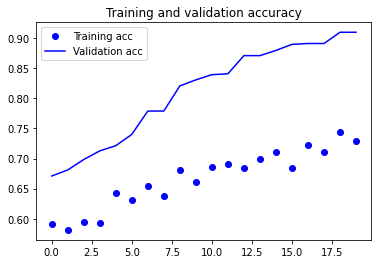

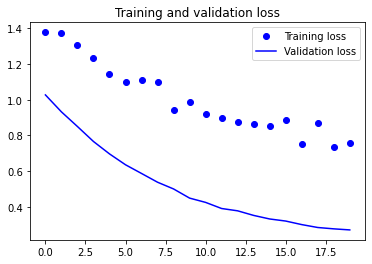

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine tuning last several layers.

In [28]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
41/41 [==============================] - 29s 554ms/step - loss: 0.7235 - acc: 0.7473 - val_loss: 0.2660 - val_acc: 0.9109
Epoch 2/20
41/41 [==============================] - 22s 517ms/step - loss: 0.7428 - acc: 0.7335 - val_loss: 0.2463 - val_acc: 0.9095
Epoch 3/20
41/41 [==============================] - 22s 513ms/step - loss: 0.7209 - acc: 0.7484 - val_loss: 0.2421 - val_acc: 0.9095
Epoch 4/20
41/41 [==============================] - 22s 511ms/step - loss: 0.7421 - acc: 0.7431 - val_loss: 0.2376 - val_acc: 0.9095
Epoch 5/20
41/41 [==============================] - 22s 530ms/step - loss: 0.6803 - acc: 0.7495 - val_loss: 0.2258 - val_acc: 0.9397
Epoch 6/20
41/41 [==============================] - 22s 519ms/step - loss: 0.7143 - acc: 0.7505 - val_loss: 0.2101 - val_acc: 0.9397
Epoch 7/20
41/41 [==============================] - 22s 512ms/step - loss: 0.7026 - acc: 0.7527 - val_loss: 0.2190 - val_acc: 0.9397
Epoch 8/20
41/41 [==============================] - 22s 520ms/step - 

In [30]:
os.makedirs("./models", exist_ok=True)
model.save('./models/cats_and_dogs_small.h5')

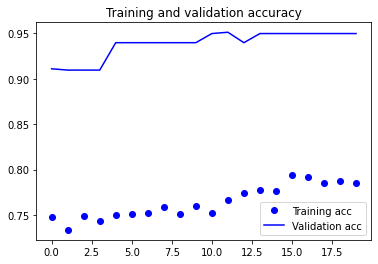

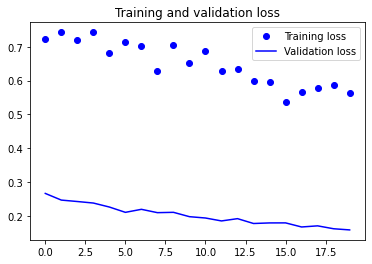

In [31]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test predict

In [32]:
cat_img = cat_images[-1]
dog_img= dog_images[-1]

In [33]:
len(cat_img) 

50

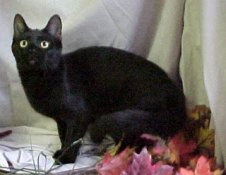

In [34]:
Image(filename=cat_img)

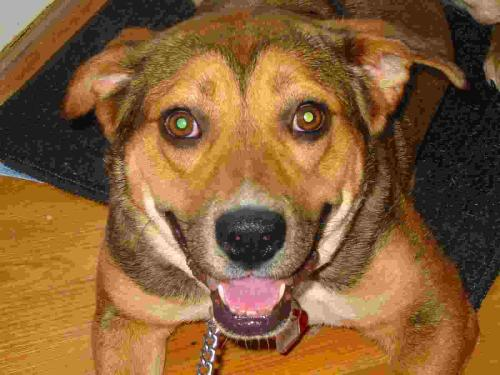

In [35]:
Image(filename=dog_img)

In [36]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    return animal,result

print(predict_image(cat_img))
print(predict_image(dog_img))

1/1 [==============================] - 2s 2s/step
('cat', 0.9447223)
1/1 [==============================] - 0s 22ms/step
('dog', 0.9999059954861877)


In [ ]:
path = [cat_images, dog_images]
class_ = ['cat', 'dog']
class_actual =[]
class_predict =[]
for p in range(len(path)):
    path_ = path[p]
    for i in path_:
        class_actual.append(class_[p])
        class_predict.append(predict_image(i)[0])

In [42]:
len(class_predict)

202

In [43]:
len(class_actual)

202

In [44]:
set(class_actual)

{'cat', 'dog'}

In [45]:
set(class_predict)

{'cat', 'dog'}

In [46]:
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(class_actual,class_predict)
cm

array([[89, 12],
       [ 4, 97]])

In [47]:
from sklearn.metrics import classification_report

print(classification_report(class_actual, class_predict))

              precision    recall  f1-score   support

         cat       0.96      0.88      0.92       101
         dog       0.89      0.96      0.92       101

    accuracy                           0.92       202
   macro avg       0.92      0.92      0.92       202
weighted avg       0.92      0.92      0.92       202



## Download the model

In [37]:
from google.colab import files

files.download('./models/cats_and_dogs_small.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
model.input_shape

(None, 150, 150, 3)

## Load the model

In [39]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [40]:
from tensorflow.keras.models import load_model
model = load_model("./models/cats_and_dogs_small.h5")